In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
resids = pd.Series.from_csv('residsNew.csv')



/anaconda2/lib/python2.7/site-packages/pandas/core/series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


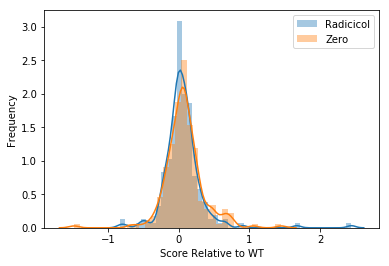

In [3]:
# Load scores of synonymous variants
my_store = pd.HDFStore('2017.07.24_Radicicol_exp.h5')
myStoreKeys = my_store.keys()
variantScores = my_store.select('/main/variants/scores')

# Keep only rows with WT sequences 
idx = variantScores.index.tolist()
idx = ['(p.=)' in name for name in idx]

variantScores = variantScores[idx]

idx = variantScores.index.tolist()
wtMuts = [name.count('(p.=)') for name in idx]
otherMuts = [name.count('(p.') for name in idx]
wtMutsOnly = []
for idMuts, muts in zip(wtMuts, otherMuts):
    wtMutsOnly.append(idMuts == muts)
    
variantScores = variantScores[wtMutsOnly]

# Remove nans from score arrays AND convert to activity scores (multiplied by -1)
varRad = variantScores.loc[:, ('Radicicol', 'score')]
varRad = -1 * varRad[~varRad.isna()]

varZero = variantScores.loc[:, ('Zero', 'score')]
varZero = -1 * varZero[~varZero.isna()]

synScores = pd.concat([varRad, varZero], axis = 1)
synScores = synScores.dropna(axis = 0)

# Plot distributions
sns.distplot(varRad, label = 'Radicicol')
sns.distplot(varZero, label = 'Zero')
plt.xlabel('Score Relative to WT')
plt.ylabel('Frequency')
plt.legend()
plt.show()

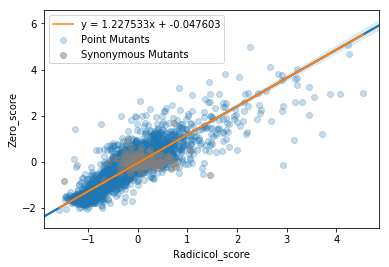

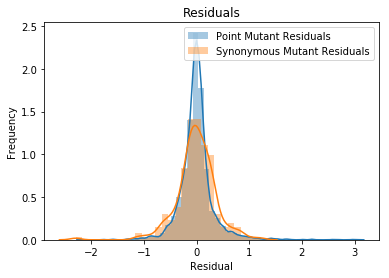

In [4]:
# Plot point mutants and line of best fit with synonymous variants on top
pointMuts = pd.read_csv('pointMuts_scores.csv', index_col = 0)

[m, b] = np.polyfit(pointMuts['Radicicol_score'], pointMuts['Zero_score'], 1)
zerPointMutsHat = (b + m * pointMuts['Radicicol_score'])
sns.regplot(pointMuts['Radicicol_score'], pointMuts['Zero_score'], scatter_kws = {'alpha':0.25}, label = 'Point Mutants')
plt.plot(pointMuts['Radicicol_score'], zerPointMutsHat, label = 'y = %fx + %f' %(m, b))
plt.scatter(synScores.loc[:, ('Zero', 'score')], synScores.loc[:, ('Radicicol', 'score')], c = 'gray', alpha = 0.5, label = 'Synonymous Mutants')
plt.legend()
plt.show()

# Calculate residuals of WT mutants
zerSynMutsHat = (b + m * synScores.loc[:, ('Zero', 'score')])
synResids = synScores.loc[:, ('Radicicol', 'score')] - zerSynMutsHat
sns.distplot(resids, label = 'Point Mutant Residuals')
sns.distplot(synResids, label = 'Synonymous Mutant Residuals')
plt.xlabel('Residual'), plt.ylabel('Frequency'), plt.title('Residuals')
plt.legend()
plt.show()

# 20190326: Analysis from Doug+Dusty meeting

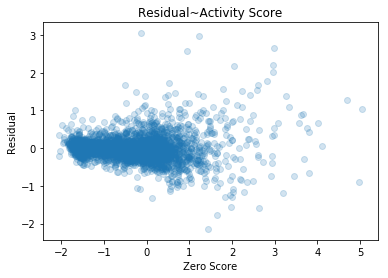

In [20]:
pointMuts = pd.read_csv('./pointMuts_scores.csv', index_col = 0)
plt.scatter(pointMuts['Zero_score'], pointMuts['Residuals'], alpha = 0.20)
plt.xlabel('Zero Score')
plt.ylabel('Residual')
plt.title('Residual~Activity Score')
plt.show()

In [81]:
coords = np.loadtxt('coords.txt')

clusterAnal = pd.DataFrame(index = np.arange(270,520), columns = ['Residuals', 'X', 'Y', 'Z'])
clusterAnal['X'] = [row[0] for row in coords]
clusterAnal['Y'] = [row[1] for row in coords]
clusterAnal['Z'] = [row[2] for row in coords]
clusterAnal['Residuals'] = 0

residSD = np.std(resids)
residMean = np.mean(resids)

clusterAnalInhib = clusterAnal.copy()
clusterAnalDepen = clusterAnal.copy()

for mut in resids.index.tolist():
    resn = int(mut[5:8])
    mutResid = resids[mut]
    if mutResid < (-residMean - residSD):
        clusterAnalDepen.loc[resn, 'Residuals'] += 1
    elif mutResid > (residMean + residSD):
        clusterAnalInhib.loc[resn, 'Residuals'] += 1

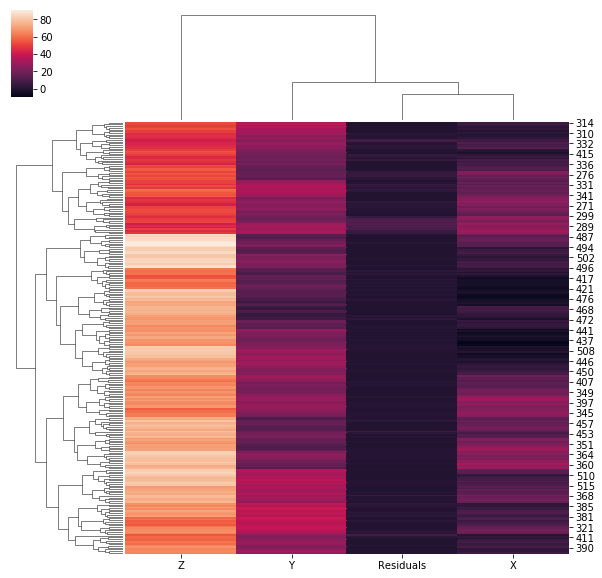

In [87]:
sns.clustermap(clusterAnalInhib)
plt.show()